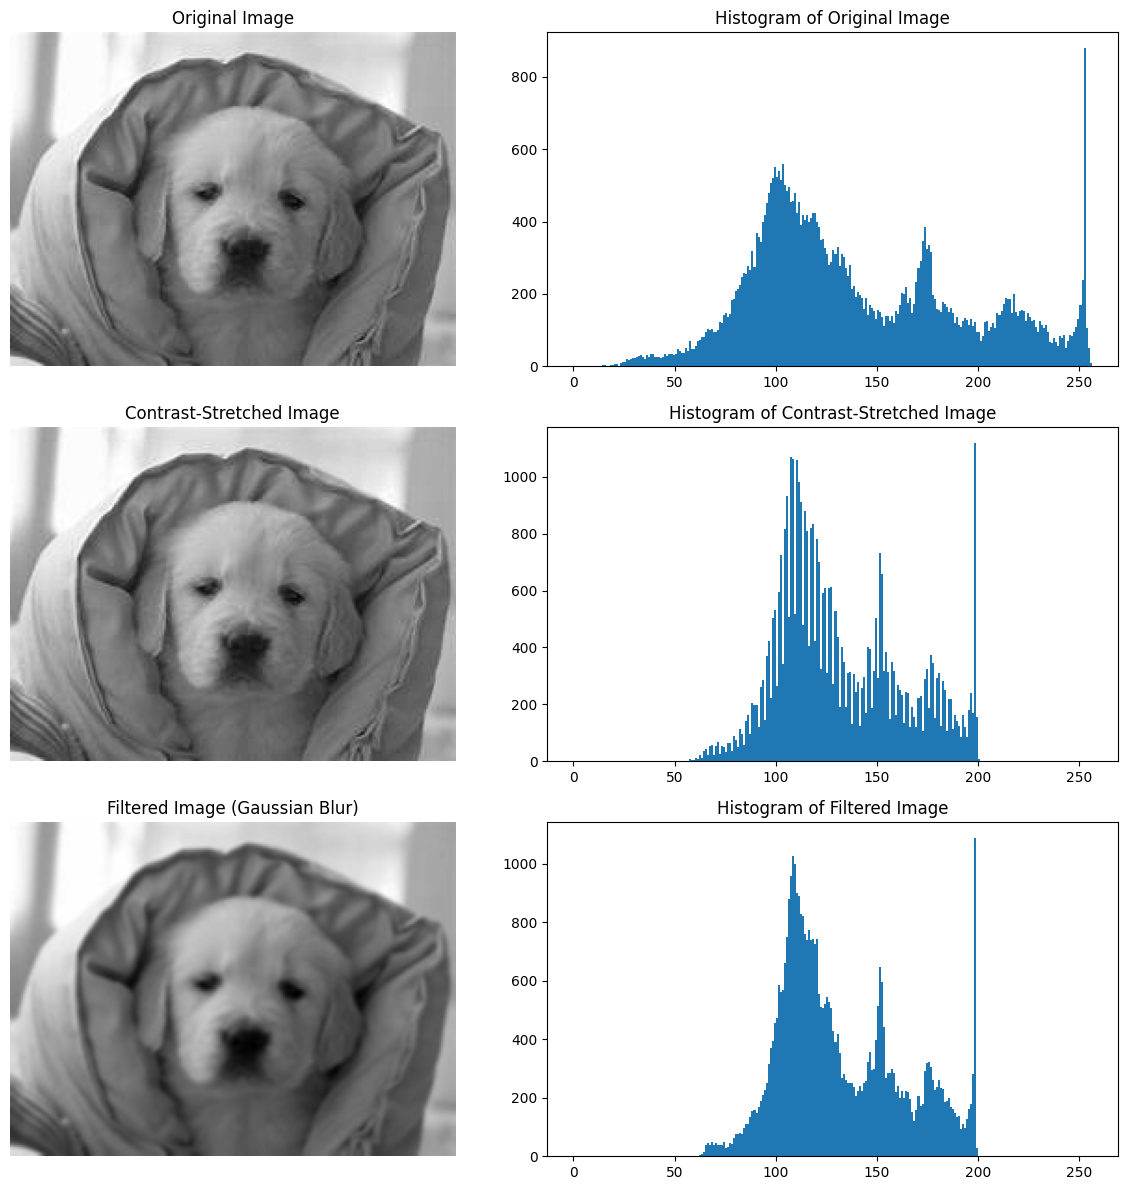

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
image = cv2.imread('imag1.png', cv2.IMREAD_GRAYSCALE)

# 1. Contrast Stretching
# Define the minimum and maximum intensity values for stretching
min_intensity, max_intensity = 50, 200

# Apply contrast stretching
stretched_image = cv2.normalize(image, None, alpha=min_intensity, beta=max_intensity, norm_type=cv2.NORM_MINMAX)

# 2. Linear Filtering (Applying a Gaussian filter for smoothing)
# Define the kernel size and apply a Gaussian filter
filtered_image = cv2.GaussianBlur(stretched_image, (5, 5), 0)

# Plotting the Original, Contrast-Stretched, and Filtered Images with Histograms
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Original Image and Histogram
axs[0, 0].imshow(image, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')
axs[0, 1].hist(image.ravel(), bins=256, range=(0, 256))
axs[0, 1].set_title("Histogram of Original Image")

# Contrast-Stretched Image and Histogram
axs[1, 0].imshow(stretched_image, cmap='gray')
axs[1, 0].set_title("Contrast-Stretched Image")
axs[1, 0].axis('off')
axs[1, 1].hist(stretched_image.ravel(), bins=256, range=(0, 256))
axs[1, 1].set_title("Histogram of Contrast-Stretched Image")

# Filtered Image and Histogram
axs[2, 0].imshow(filtered_image, cmap='gray')
axs[2, 0].set_title("Filtered Image (Gaussian Blur)")
axs[2, 0].axis('off')
axs[2, 1].hist(filtered_image.ravel(), bins=256, range=(0, 256))
axs[2, 1].set_title("Histogram of Filtered Image")

# Show all plots
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping

# a) Load the dataset
# Assuming the Horse or Human dataset is organized in subfolders (train and validation)
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/horse-or-human/horse-or-human'

# Define the paths to the horse and human image folders
horse_dir = os.path.join(base_dir, 'horses')
human_dir = os.path.join(base_dir, 'humans')

# Load images from both classes (horse and human)
horse_images = [os.path.join(horse_dir, f) for f in os.listdir(horse_dir)]
human_images = [os.path.join(human_dir, f) for f in os.listdir(human_dir)]

# Show the number of images in each class
print(f"Number of horse images: {len(horse_images)}")
print(f"Number of human images: {len(human_images)}")

# Plot some images from both classes
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

# Display a few horse images
for i, img_path in enumerate(horse_images[:2]):
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    axes[i].imshow(img_array.astype('uint8'))
    axes[i].set_title(f"Horse Image {i+1}")
    axes[i].axis('off')

# Display a few human images
for i, img_path in enumerate(human_images[:2]):
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    axes[i+2].imshow(img_array.astype('uint8'))
    axes[i+2].set_title(f"Human Image {i+1}")
    axes[i+2].axis('off')

plt.show()

# Image Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Set up data generators for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Define the CNN model (using ResNet for transfer learning)
model = Sequential([
    ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=train_generator,
    validation_steps=50,
    callbacks=[early_stopping]
)

# Show the training and testing accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()
